In [74]:
from typing import List, Callable

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation, cm, cbook

from tqdm.notebook import tqdm

In [98]:
def U_paraboloid(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    x_hat = x - np.array([a, b])
    return c * x_hat.dot(x_hat)

def grad_U_paraboloid(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    x_hat = x - np.array([a, b])
    return 2 * c * x_hat

def U_valley(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return c * (x[0]-a)**2

def grad_U_valley(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return 2 * c * (x[0]-a)

def U_crossing(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return c * min((x[0]-a)**2, (x[1]-b)**2)

def grad_U_crossing(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return np.array([
        2 * c * max((x[0] - a), 0.),
        2 * c * max((x[1] - b), 0.),
    ])

def U(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return U_crossing(x, a=a, b=b, c=c)

def grad_U(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return grad_U_crossing(x, a=a, b=b, c=c)

def get_U_contour(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1)):
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = U(np.array([X[i, j], Y[i, j]]), a=a, b=b, c=c)

            if Z[i, j] > zlim:
                Z[i, j] = np.nan

    return X, Y, Z

def get_stationary_dist_contour(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), beta=1.):
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            potential = U(np.array([X[i, j], Y[i, j]]), a=a, b=b, c=c)
            Z[i, j] = np.exp(-beta * potential)

            if Z[i, j] > zlim:
                Z[i, j] = np.nan

    return X, Y, Z

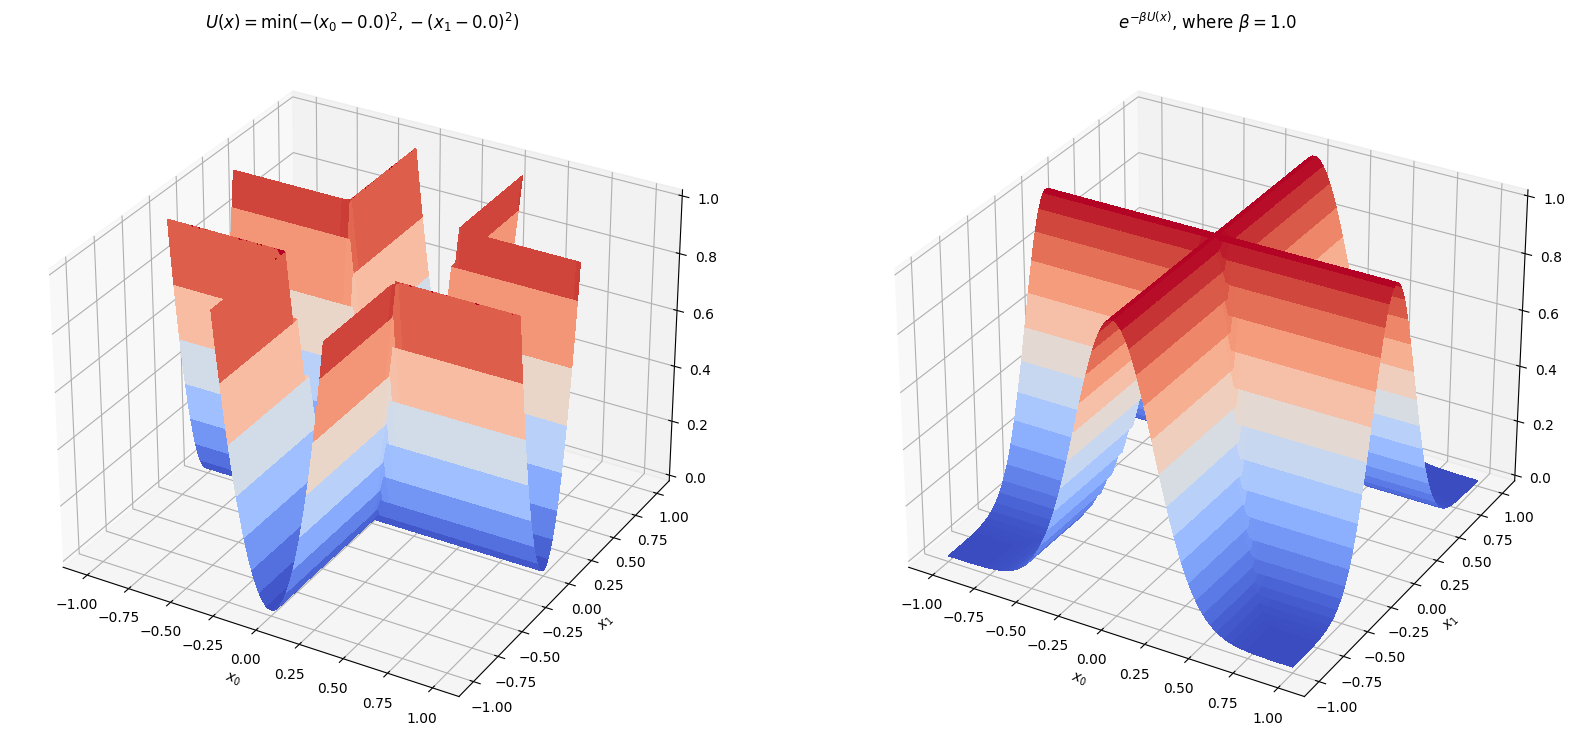

In [99]:
def plot_U_3D(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), ax=None):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Max height = 1
    ax.set_zlim(0, zlim)

    ax.set_title(f"$U(x) = \min(-(x_0-{a})^2, -(x_1-{b})^2)$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax


def plot_stationary_dist_3D(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), ax=None, beta=1.):
    X, Y, Z = get_stationary_dist_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim, beta=1.)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Max height = 1
    ax.set_zlim(0, zlim)

    ax.set_title(f"$e^{{-\\beta U(x)}}$, where $\\beta={beta}$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax


fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

plot_U_3D(c=10, ax=axes[0])
plot_stationary_dist_3D(c=10, ax=axes[1])
plt.show()

In [61]:
def plot_U_2D(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1)):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.contour(X, Y, Z, levels=20, cmap=cm.coolwarm)
    ax.set_title(f"$H(x, v) = U(x) + K(v)$\n$U(x) = \min(-(x_0-{a})^2, -(x_1-{b})^2)$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return fig, ax

def plot_walk_2D(walk: np.ndarray, a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1)):
    fig, ax = plot_U_2D(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # Break apart the walk into sections that don't involve wrapping around the torus
    # I.e.: split at large jumps
    split_indices = np.where(np.linalg.norm(walk[1:] - walk[:-1], axis=1) > 0.5)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(walk)]))

    for i in range(len(split_indices) - 1):
        start = split_indices[i]
        end = split_indices[i + 1]

        ax.plot(walk[start:end, 0], walk[start:end, 1], color='black', linewidth=0.5, alpha=0.1)
        ax.scatter(walk[start:end, 0], walk[start:end, 1], color='black', s=5, alpha=0.1)
    
    return fig, ax

Simulating particle...:   0%|          | 0/100000 [00:00<?, ?it/s]

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: title={'center': '$H(x, v) = U(x) + K(v)$\n$U(x) = \\min(-(x_0-0.0)^2, -(x_1-0.0)^2)$'}, xlabel='$x_0$', ylabel='$x_1$'>)

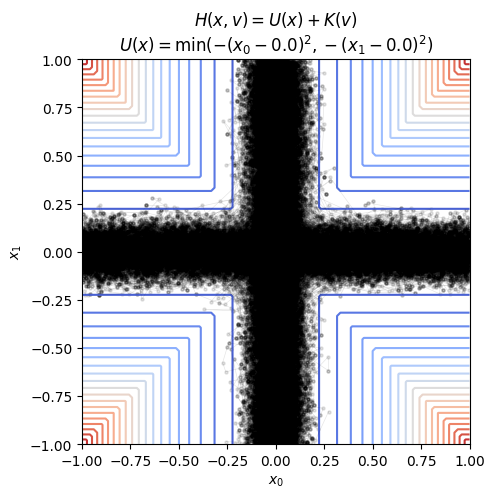

In [95]:
def leapfrog_update(x, p, epsilon=1e-6):
    p -= epsilon * grad_U(x) / 2.
    x += epsilon * p
    p -= epsilon * grad_U(x) / 2.
    return x, p

def wrap_torus(x, xlim, ylim):
    x[0] = (x[0] - xlim[0]) % (xlim[1] - xlim[0]) + xlim[0]
    x[1] = (x[1] - ylim[0]) % (ylim[1] - ylim[0]) + ylim[0]
    
    return x

def simulate_particle(
    a = 0., 
    b = 0., 
    c: float = 1., 
    x0: np.ndarray = np.array([0., 0.]), 
    epsilon: float = 1e-3,
    dt: float = 0.1, 
    n_steps: int = 1000, 
    xlim=(-1., 1.), 
    ylim=(-1., 1.)
):
    x = x0
    xs = [x]

    E_old = U(x, a=a, b=b, c=c)

    for i in tqdm(range(n_steps), desc="Simulating particle..."):
        # Hamiltonian Monte Carlo
        x_new = x.copy()
        p = np.random.normal(0, 1, size=2)
        K = p @ p / 2.

        E_old = U(x, a=a, b=b, c=c) + K

        # Leapfrog integration
        for i in range(int(dt // epsilon)):
            x_new, p = leapfrog_update(x_new, p, epsilon=epsilon)
                
        x_new = wrap_torus(x_new, xlim=xlim, ylim=ylim)

        # Gibbs sampling step
        K_new = p @ p / 2.
        E_new = U(x_new, a=a, b=b, c=c) + K_new

        if np.random.uniform() < np.exp(-(E_new - E_old)):
            x = x_new
            
        xs.append(x)        

    return np.array(xs)

xs = simulate_particle(dt=0.1, x0=np.array([0., 0.]), n_steps=100000, c=100.)

plot_walk_2D(xs, c=1, xlim=(-1, 1), ylim=(-1, 1))

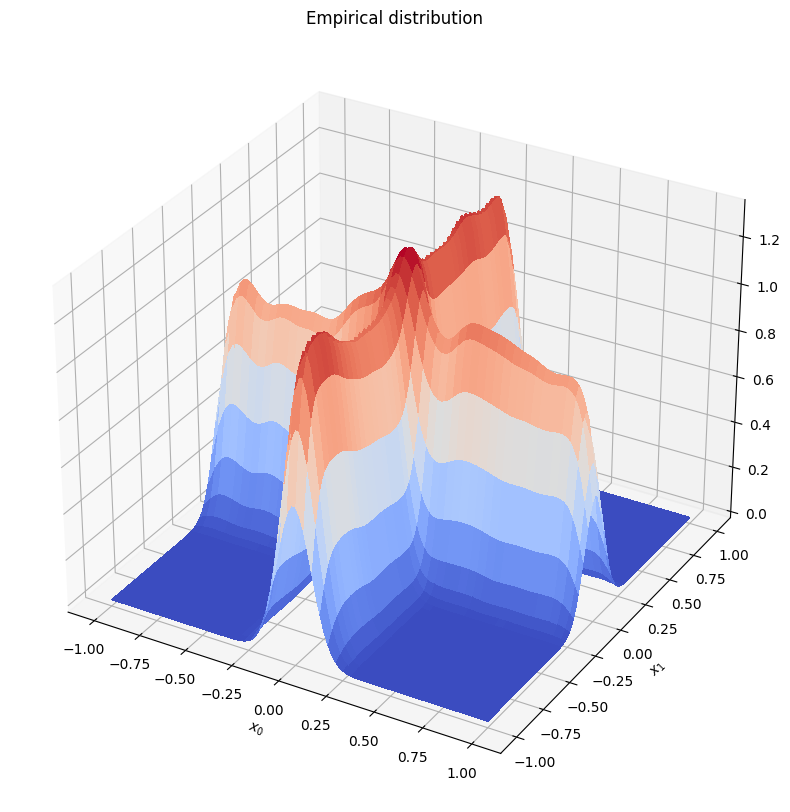

In [96]:
from scipy.stats import gaussian_kde

def plot_empirical_dist_3D(walk: np.ndarray, a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), ax=None):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    # Kernel density estimation
    kde = gaussian_kde(xs.T)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_title(f"Empirical distribution")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return kde, Z, ax

walk_kde, Z, ax = plot_empirical_dist_3D(xs, c=100, xlim=(-1, 1), ylim=(-1, 1))

In [64]:
def particle_stats(xs):

    df = pd.DataFrame(np.concatenate([xs, vs], axis=1), columns=["x0", "x1", "v0", "v1"])
    df["U"] = df.apply(lambda row: U(np.array([row["x0"], row["x1"]])), axis=1)

    return df

df = particle_stats(xs)
df

,x0,x1,v0,v1,U
0,0.500000,0.000000,0.0,0.0,0.000000
1,0.496209,0.009342,0.0,0.0,0.000087
2,0.494395,0.012736,0.0,0.0,0.000162
3,0.492998,0.009887,0.0,0.0,0.000098
4,0.484266,0.010315,0.0,0.0,0.000106
...,...,...,...,...,...
99996,0.423871,0.080769,0.0,0.0,0.006524
99997,0.417044,0.075610,0.0,0.0,0.005717
99998,0.406211,0.072686,0.0,0.0,0.005283
99999,0.402531,0.069969,0.0,0.0,0.004896


Animating particle...:   0%|          | 0/100 [00:00<?, ?it/s]

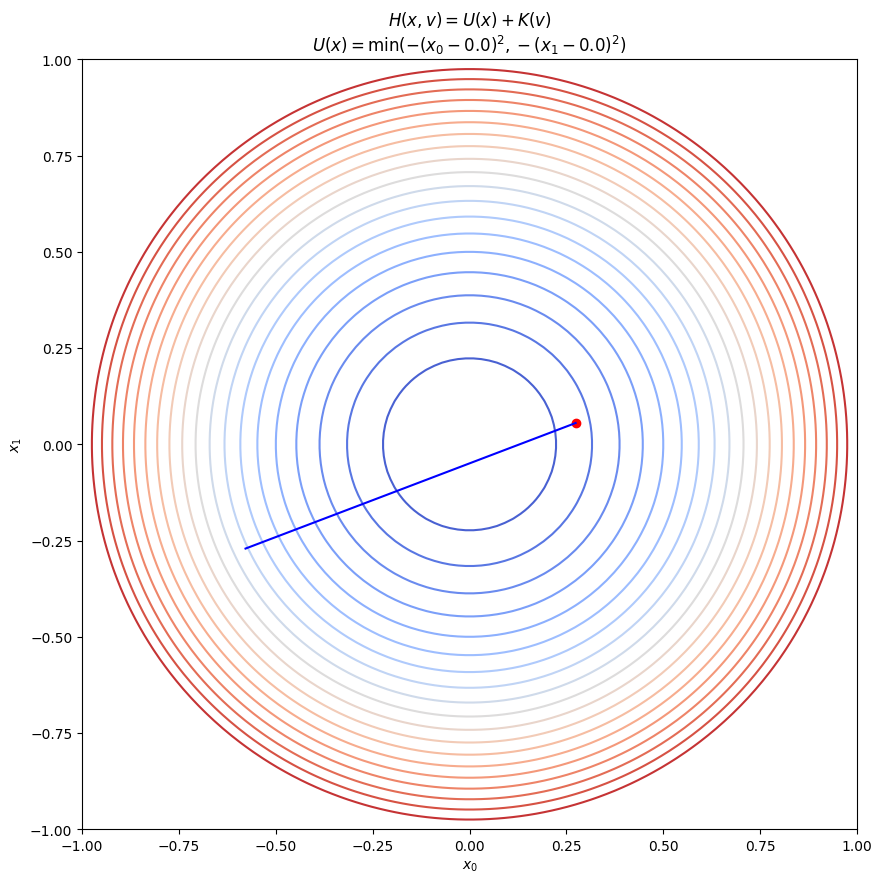

In [166]:
def animate_particle(xs: np.ndarray, vs: np.ndarray, a=0., b=0., c: float = 1., zlim=1., xlim=(-1, 1), ylim=(-1,1), fps: int = 30, save: bool = False, filename: str = "particle.mp4"):
    # Draw the point
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # In 2D
    fig, ax = plot_U_2D(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # Draw the point
    point, = ax.plot([], [], 'o', color="red")

    # Draw the velocity (as an arrow)
    velocity, = ax.plot([], [], color="blue")

    # Animation loop

    progress = tqdm(total=len(xs), desc="Animating particle...")

    def animate(i):
        point.set_data(xs[i, 0], xs[i, 1])
        velocity.set_data([xs[i, 0], xs[i, 0] + vs[i, 0]], [xs[i, 1], xs[i, 1] + vs[i, 1]])

        progress.update(1)

        return point, velocity
    
    anim = animation.FuncAnimation(fig, animate, frames=len(xs), interval=10_000/fps, blit=True)

    if save:
        anim.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])

    return anim


animate_particle(xs[:10_0], vs[:10_0], fps=30, save=True, filename="particle.mp4")